# Import and Load Model

In [ ]:
# #make sure directory exist
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/ECE1508/PROJ/

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F

from utils import linear_schedule,sigmoid_beta_schedule, add_noise, denoise_step, sample_plot_image, show_tensor_image
from diffusion_model import Unet

In [ ]:
# if loading models and data through google drive, use code below, although loading data from drive is extrememly slow

In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np

IMG_SIZE = 64
BATCH_SIZE = 10
img_size = IMG_SIZE

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
T = 1000  # Total number of timesteps
# Precompute terms for the diffusion process
betas = sigmoid_beta_schedule(T).to(device)  # [T]
alphas = 1.0 - betas  # [T]
alphas_cumprod = torch.cumprod(alphas, dim=0)  # [T]

In [ ]:
from torch.optim import Adam
model_pet = Unet()
model_pet.load_state_dict(torch.load('./models/model_OxfordPet_dog_v4.pth'))

device = torch.device("cuda")
model_pet.to(device)


model_car = Unet()
model_car.load_state_dict(torch.load('./models/model_cifar10_car_v4.pth'))

device = torch.device("cuda")
model_car.to(device)
#model.eval()  # or model.train()

Unet(
  (conv0): Block(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): GELU(approximate='none')
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): GELU(approximate='none')
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (down1): Down(
    (down_conv_block): Sequential(
      (0): Block(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): GELU(approximate='none')
          (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): GELU(approximate='none')
          (5): BatchNorm2d(128, ep

# image generate from pure noise

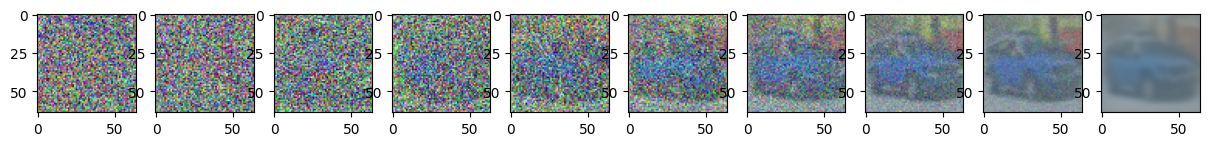

In [ ]:
sample_plot_image(model_car,img_size)

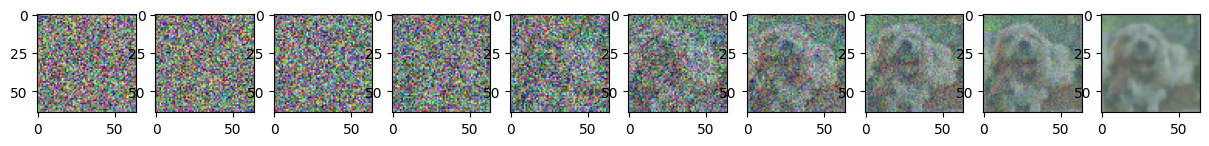

In [ ]:
sample_plot_image(model_pet,img_size)

# Denoise Image

this part we test the denoise capability by adding noise to an image then denoise it intead of generating new images from noise

In [ ]:
def get_data(img_size=64):
    data_transforms = torchvision.transforms.Compose([
        transforms.Resize(img_size + int(.25*img_size)),  # img_size + 1/4 *img_size
        transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
        transforms.ToTensor(),
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1]
    ])


    train_dataset = datasets.OxfordIIITPet(root='./data', split='trainval', download=True,transform=data_transforms)
    val_dataset = datasets.OxfordIIITPet(root='./data', split='test', download=True,transform=data_transforms)


    def filter_label_zero(dataset):
        indices = [i for i, (_, label) in enumerate(dataset) if label in [2,3,4,15]]
        return Subset(dataset, indices)

    train_filtered = filter_label_zero(train_dataset)
    test_filtered = filter_label_zero(val_dataset)

    combined_dataset = torch.utils.data.ConcatDataset([train_filtered,test_filtered])
    return combined_dataset


In [ ]:
IMG_SIZE = 64
BATCH_SIZE = 10
data = get_data()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True)

sample image from the dataset with noise added

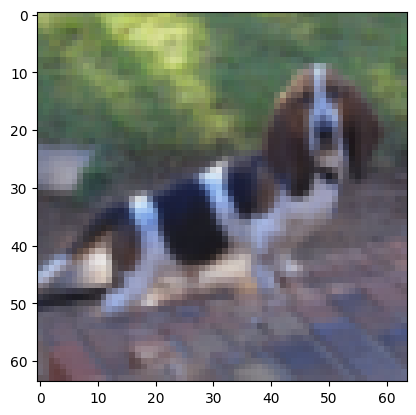

In [ ]:
image = next(iter(dataloader))[0]
show_tensor_image(image)

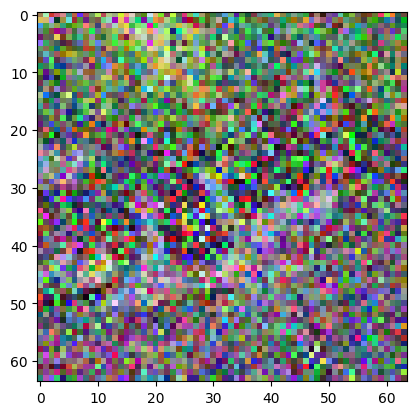

In [ ]:
t = torch.Tensor([300]).type(torch.int64).cuda()
x_noisy, noise = add_noise(image, t)
x_noisy
show_tensor_image(x_noisy.to('cpu'))

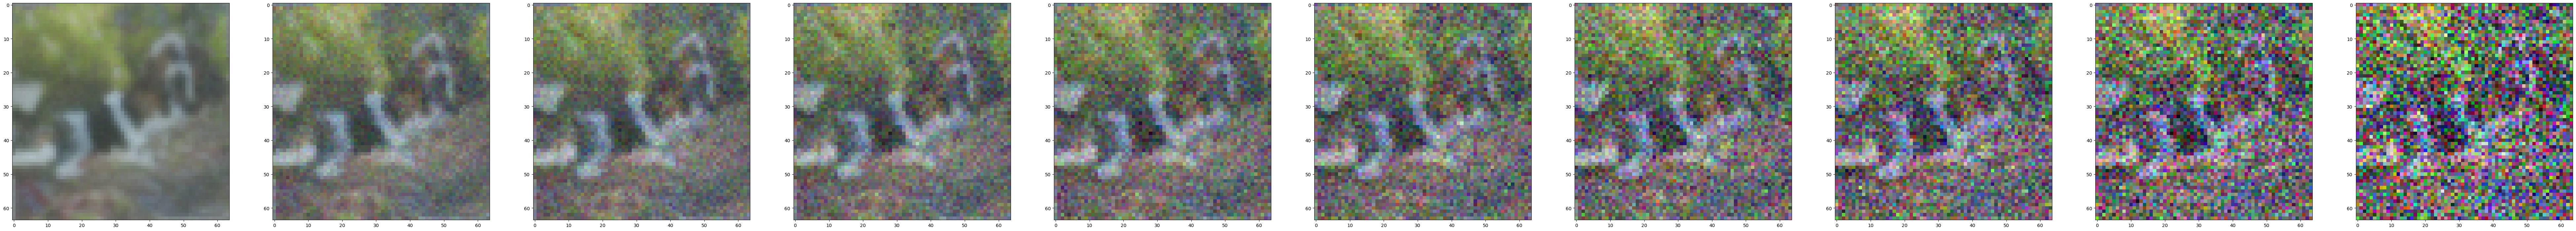

In [ ]:
num_images = 10
stepsize = int(400/num_images)
t = torch.Tensor([400]).type(torch.int64).cuda()
img, noise = add_noise(image, t)
plt.figure(figsize=(100, 80))
with torch.no_grad():
  for i in range(0,400)[::-1]:
    #print(i)
    t = torch.full((1,), i, device=device, dtype=torch.long)
    img = denoise_step(img, t, model_pet)
    #print(img)
    # maintain the natural range of the distribution
    img = torch.clamp(img, -1.0, 1.0)
    #if i % stepsize == 0:
    plt.subplot(1, num_images, int(i/stepsize)+1)
    show_tensor_image(img.detach().cpu())
  plt.show()